In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import math

In [2]:
training_data = np.genfromtxt('Training_data.csv', delimiter=',', names=True,dtype=None)

In [3]:
print(training_data.dtype.names)

('bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23', 'bin24', 'bin25', 'bin26', 'bin27', 'bin28', 'bin29', 'String', 'Module', 'POCAM_zPostion', 'Distnace', 'Module_zPosition', 'Scattering')


In [4]:
t_columns = ['String', 'Module', 'POCAM_zPostion', 'Distnace', 'Module_zPosition', 'Scattering']
x_columns = training_data.dtype.names[:30]
x_columns = [*x_columns]

In [5]:
t = np.column_stack([training_data[col] for col in t_columns])

x = np.column_stack([training_data[col] for col in x_columns])

In [9]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.float32)
t_test = torch.tensor(t_test, dtype=torch.float32)


In [10]:
indicies = torch.randint(0, len(x_test), (32,))
test_histograms = x_test[indicies]
conditionx = t_train[indicies]
print(conditionx.shape)
print(conditionx[0])

torch.Size([32, 6])
tensor([7.9000e+01, 2.2000e+01, 2.1931e+03, 1.6960e+01, 2.1843e+03, 4.6433e-02])


In [8]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim, bins, hidden_dim):
        super().__init__()
        self.Model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim),
            
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim),

            torch.nn.Linear(hidden_dim, hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            
            torch.nn.Linear(hidden_dim *4, hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            
            torch.nn.Linear(hidden_dim * 4, hidden_dim * 8),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim * 8),
            
            torch.nn.Linear(hidden_dim * 8, hidden_dim * 8),
            torch.nn.LeakyReLU(0.2),
            torch.nn.BatchNorm1d(hidden_dim * 8),

            torch.nn.Linear(hidden_dim * 8, bins),
            torch.nn.Softplus()

        )

    def forward(self, x):
        return self.Model(x)       

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self, bins, input_dim, hidden_dim):
        super().__init__()
        self.Model = torch.nn.Sequential(
            torch.nn.Linear(input_dim+bins, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim, hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 8),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 8, hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 2, hidden_dim // 2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim // 2, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, hist,cond):
        x = torch.cat([hist,cond], dim=1)
        return self.Model(x)


In [10]:
class HistGenerator:
    def __init__(self, x_test, x_train, t_test, t_train, input_dim = 6, bins = 30, hidden_dim = 64):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.x_test=x_test
        self.x_train=x_train
        self.t_test=t_test
        self.t_train=t_train
        self.bins=bins

        self.generator = Generator(input_dim, bins, hidden_dim)
        self.discriminator = Discriminator(bins, input_dim,hidden_dim)

        self.gen_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        self.discri_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0003, betas=(0.5, 0.999))

        self.criterion = torch.nn.BCELoss()

        self.d_losses = []
        self.g_losses = []

    def training(self, batch_size):
        ##Trainng the discriminator ##
        self.discriminator.zero_grad()       

        ##data
        indicies = torch.randint(0, len(self.x_train), (batch_size,))
        real_hist = self.x_train[indicies] 
        conditions = self.t_train[indicies]       
        real_labels = torch.ones(batch_size, 1)

        real_output = self.discriminator(real_hist, conditions)
        real_loss_dis = self.criterion(real_output, real_labels)

        ##Fake histograms
        fake_hist = self.generator(conditions)
        fake_labels = torch.zeros(batch_size, 1)

        fake_output = self.discriminator(fake_hist.detach(), conditions)
        fake_loss_dis = self.criterion(fake_output, fake_labels)

        disc_loss = real_loss_dis + fake_loss_dis
        disc_loss.backward()
        self.discri_optim.step()

        ## Training Generator ##

        self.generator.zero_grad()

        fake_hist = self.generator(conditions)
        
        ## Fooling the discriminator ## 

        output = self.discriminator(fake_hist, conditions)
        g_loss = self.criterion(output,real_labels)

        g_loss.backward()
        self.gen_optim.step()

        return disc_loss.item(), g_loss.item()
    
    def evaluate(self, n_samples=100, batch_size=64):
        self.generator.eval()
        self.discriminator.eval()

        with torch.no_grad():
            indicies = torch.randint(0, len(self.x_test), (batch_size,))
            conditions = self.t_test[indicies]
            fake_histograms = self.generator(conditions)
            test_histograms = self.x_test[indicies]

            if isinstance(test_histograms, torch.Tensor):
                print("Is Tensor")
            else:
                print("Is  not Tensor")

            test_scores = self.discriminator(test_histograms, conditions)
            #test_scores = test_scores.numpy()

            gen_scores = self.discriminator(fake_histograms, conditions)
            #gen_scores = gen_scores.numpy()
        
        self.generator.train()
        self.discriminator.train()

        metrics = {
            'test_mean_count': test_histograms.mean(),
            'gen_mean_count': fake_histograms.mean(),
            'test_std': test_histograms.std(),
            'gen_std': fake_histograms.std(),
            'test_disc_score': test_scores.mean(),
            'gen_disc_score': gen_scores.mean(),
        }
        
        return metrics
            

    
    def train(self, epochs, batch_size = 64, print_every = 150, eval_every=500):

        print(f"Training the network for {epochs} epochs")

        for epoch in range(epochs):
            disc_loss, g_loss = self.training(batch_size)

            self.d_losses.append(disc_loss)
            self.g_losses.append(g_loss)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch [{epoch + 1}/{epoch}] | Discriminator Loss: {disc_loss:.4f} | Generator Loss: {g_loss:.4f}")
            
            if (epoch+1) % eval_every == 0:
                metrics = self.evaluate()
                print(f"\n--- Test Set Evaluation (Epoch {epoch+1}) ---")
                print(f"  Test mean count: {metrics['test_mean_count']:.2f}")
                print(f"  Gen mean count:  {metrics['gen_mean_count']:.2f}")
                print(f"  Discriminator score on test: {metrics['test_disc_score']:.3f}")
                print(f"  Discriminator score on gen:  {metrics['gen_disc_score']:.3f}")
                print("-" * 60 + "\n")


    def generate_histograms(self, input_vectors):
        """Generate histograms from input vectors"""
        self.generator.eval()
        with torch.no_grad():
            if isinstance(input_vectors, np.ndarray):
                input_vectors = torch.FloatTensor(input_vectors)
            histograms = self.generator(input_vectors)
        self.generator.train()
        return histograms.numpy()
        
    def plot_results(self, n = 4):
        indicies = torch.randint(0, len(x_test), (n,))
        
        conditions = t_test[indicies]
        fake_hist = self.generate_histograms(conditions)

        test_histograms = x_test[indicies]
        grid_size = int(math.sqrt(n))
        fig, axes = plt.subplots(grid_size, grid_size, figsize = (15,6))
        for i in range(n):
            row = i // grid_size
            col = i % grid_size
            ## Here real histograms are to be plotted ##
            axes[row, col].plot(range(self.bins), test_histograms[i], color = 'blue', alpha=0.7, label='Data')
            axes[row, col].plot(range(self.bins), fake_hist[i], color='red', alpha=0.7, label='Generated')
            axes[row, col].set_ylabel('Counts')
    
        plt.tight_layout()
        plt.legend()
        plt.show() 

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(self.g_losses, label='Generator Loss', alpha=0.7)
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('GAN Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()  
        





Training the network for 2000 epochs
Epoch [200/199] | Discriminator Loss: 1.4127 | Generator Loss: 0.7184
Epoch [400/399] | Discriminator Loss: 1.3679 | Generator Loss: 0.7061
Is Tensor

--- Test Set Evaluation (Epoch 500) ---
  Test mean count: 1.99
  Gen mean count:  1.47
  Discriminator score on test: 0.489
  Discriminator score on gen:  0.489
------------------------------------------------------------

Epoch [600/599] | Discriminator Loss: 1.3885 | Generator Loss: 0.6908
Epoch [800/799] | Discriminator Loss: 1.3726 | Generator Loss: 0.7029
Epoch [1000/999] | Discriminator Loss: 1.3982 | Generator Loss: 0.7062
Is Tensor

--- Test Set Evaluation (Epoch 1000) ---
  Test mean count: 9.48
  Gen mean count:  2.87
  Discriminator score on test: 0.508
  Discriminator score on gen:  0.483
------------------------------------------------------------

Epoch [1200/1199] | Discriminator Loss: 1.3570 | Generator Loss: 0.6953
Epoch [1400/1399] | Discriminator Loss: 1.3782 | Generator Loss: 0.70

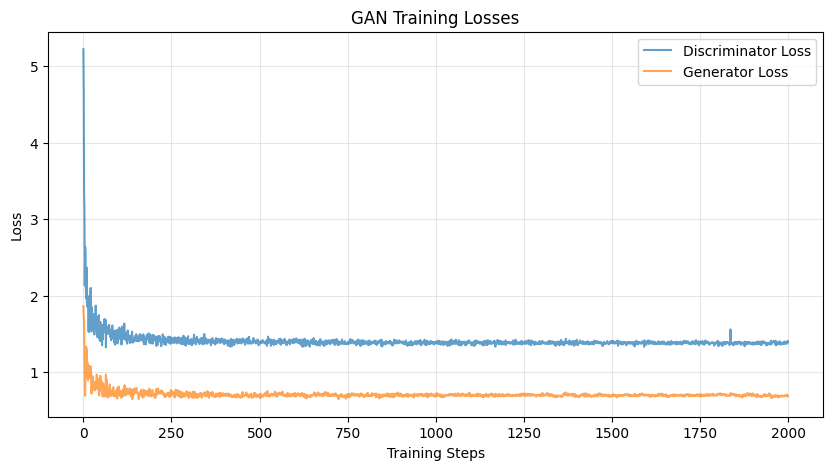

In [11]:
gan = HistGenerator(x_test=x_test,
                    x_train=x_train,
                    t_test=t_test,
                    t_train=t_train,
                    input_dim=6, 
                    bins=30, 
                    hidden_dim=64,
                    )

gan.train(epochs=2000, 
          batch_size=64, 
          print_every=200, 
          eval_every=500
          )

gan.plot_loss()




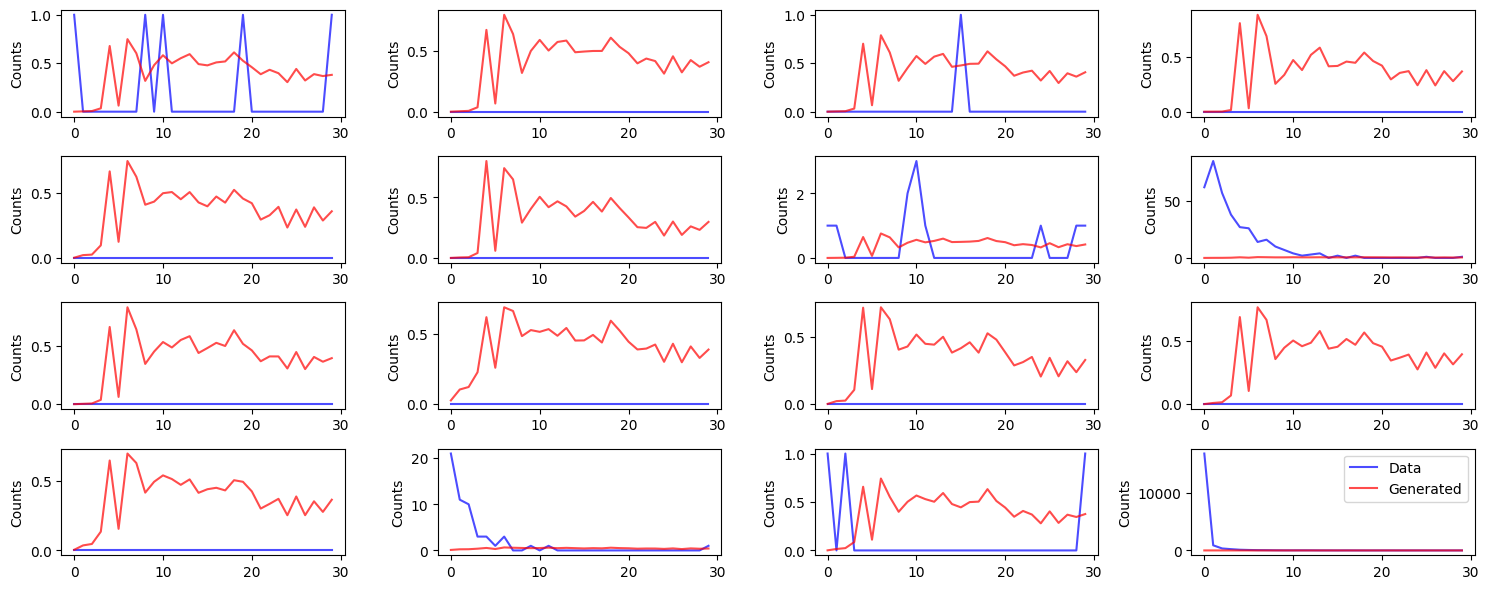

In [15]:
gan.plot_results(n=16)